In [115]:
#!wget https://dataworks.indianapolis.iu.edu/bitstream/handle/11243/41/data.zip
#!unzip -q data.zip
#!rm data.zip

In [116]:
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import reduce

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset definition

In [117]:
class ImageDNATrainDataset():
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1

        TRAINING_SAMPLES_NUMBER = 12481
        TRAINING_LABELS_NUMBER = 652

        assert len(train_loc[0]) == TRAINING_SAMPLES_NUMBER

        indeces = train_loc
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(
            data_mat["embeddings_img"][indeces]
        ).float()
        self.embeddings_dna = torch.from_numpy(
            data_mat["embeddings_dna"][indeces]
        ).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        species_mapping = seen_species_mapping
        assert len(species_mapping) == TRAINING_LABELS_NUMBER

        species = data_mat["labels"][indeces]
        remapped_species = np.array([species_mapping[label.item()] for label in species])
        self.remapped_species = torch.from_numpy(remapped_species).long()

        assert len(torch.unique(self.remapped_species)) == TRAINING_LABELS_NUMBER

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        assert len(self.genera) == TRAINING_SAMPLES_NUMBER

        self.species_names = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_species[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

## Validation set
- Number of samples: 6939.
- Number of seen species of the training set in the validation set: 629.
- Number of unseen species in the validation set: 97

In [118]:
class ImageDNAValidationDataset():
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_LABELS_NUMBER = 652
        VALIDATION_SAMPLES_NUMBER = 6939
        VALIDATION_SPECIES_NUMBER = 774
        TRAINING_VALIDATION_SPECIES_NUMBER = 797
        VALIDATION_SEEN_SPECIES_NUMBER = 629
        VALIDATION_UNSEEN_SPECIES_GENERA_NUMBER = 97

        indeces = np.concatenate((val_seen_loc, val_unseen_loc), axis=1)
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]
        assert len(indeces) == VALIDATION_SAMPLES_NUMBER

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species = data_mat["labels"][val_unseen_loc][0]
        unseen_species_mapping = {label: i + TRAINING_LABELS_NUMBER for i, label in enumerate(np.unique(unseen_species))}

        # Union of the two mappings, allows to fully remap all the labels
        species_mapping = seen_species_mapping | unseen_species_mapping
        assert len(species_mapping) == TRAINING_VALIDATION_SPECIES_NUMBER

        species = data_mat["labels"][indeces]
        remapped_species = np.array([species_mapping[label.item()] for label in species])
        self.remapped_species = torch.from_numpy(remapped_species).long()
        assert len(torch.unique(self.remapped_species)) == VALIDATION_SPECIES_NUMBER

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        # Compute genera of unseen species in the validation set
        unseen_species_genera = []
        for i in val_unseen_loc[0]:
            unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)
        self.unseen_species_genera = np.array(unseen_species_genera)
        assert len(np.unique(self.unseen_species_genera)) == VALIDATION_UNSEEN_SPECIES_GENERA_NUMBER

        # Compute seen species number in the validation set
        seen_species = []
        for i in val_seen_loc[0]:
            seen_species.append(species_mapping[data_mat["labels"][i].item()])
        self.seen_species = np.array(seen_species)
        assert len(np.unique(self.seen_species)) == VALIDATION_SEEN_SPECIES_NUMBER

        self.species_names = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_species[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

## Test set
- Number of samples: 13428.
- Number of seen species of the training and validation set in the test set: 770.
- Number of unseen species in the test set: 134

In [119]:
class ImageDNATestDataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_SPECIES_NUMBER = 652
        TRAINING_VALIDATION_SPECIES = 797
        NUMBER_OF_SPECIES = 1040
        TEST_SEEN_SPECIES_NUMBER = 770
        TEST_UNSEEN_SPECIES_GENERA_NUMBER = 134

        indeces = np.concatenate((test_seen_loc, test_unseen_loc), axis=1)
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species_validation = data_mat["labels"][val_unseen_loc][0]
        unseen_species_validation_mapping = {label: i + TRAINING_SPECIES_NUMBER for i, label in enumerate(np.unique(unseen_species_validation))}

        # Remap unseen species during test in [797, 1039]
        unseen_species_test = data_mat["labels"][test_unseen_loc][0]
        unseen_species_test_mapping = {label: i + TRAINING_VALIDATION_SPECIES for i, label in enumerate(np.unique(unseen_species_test))}

        assert reduce(np.intersect1d, (seen_species, unseen_species_validation, unseen_species_test)).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = seen_species_mapping | unseen_species_validation_mapping | unseen_species_test_mapping
        assert len(labels_mapping) == NUMBER_OF_SPECIES

        species = data_mat["labels"][indeces]
        remapped_labels = np.array([labels_mapping[label.item()] for label in species])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        # Compute genera of unseen species
        unseen_species_genera = []
        for i in test_unseen_loc[0]:
            unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)

        self.unseen_species_genera = np.array(unseen_species_genera)
        assert len(np.unique(self.unseen_species_genera)) == TEST_UNSEEN_SPECIES_GENERA_NUMBER

        # Compute seen species
        seen_species = []
        for i in test_seen_loc[0]:
            seen_species.append(labels_mapping[data_mat["labels"][i].item()])
        self.seen_species = np.array(seen_species)
        assert len(np.unique(self.seen_species)) == TEST_SEEN_SPECIES_NUMBER

        self.species_name = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

In [120]:
class ImageDNATrainValidationDataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_SPECIES_NUMBER = 652
        TRAINING_VALIDATION_SPECIES = 797
        NUMBER_OF_SPECIES = 1040

        indeces = trainval_loc
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species_validation = data_mat["labels"][val_unseen_loc][0]
        unseen_species_validation_mapping = {label: i + TRAINING_SPECIES_NUMBER for i, label in enumerate(np.unique(unseen_species_validation))}

        # Remap unseen species during test in [797, 1039]
        unseen_species_test = data_mat["labels"][test_unseen_loc][0]
        unseen_species_test_mapping = {label: i + TRAINING_VALIDATION_SPECIES for i, label in enumerate(np.unique(unseen_species_test))}

        assert reduce(np.intersect1d, (seen_species, unseen_species_validation, unseen_species_test)).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = seen_species_mapping | unseen_species_validation_mapping | unseen_species_test_mapping
        assert len(labels_mapping) == NUMBER_OF_SPECIES

        species = data_mat["labels"][indeces]  # Consider only train
        remapped_labels = np.array([labels_mapping[label.item()] for label in species])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()

        assert len(torch.unique(self.remapped_labels)) == TRAINING_VALIDATION_SPECIES

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        self.species = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera


# Model definition

In [121]:
class AttentionNet2(nn.Module):
        def __init__(self, num_seen_species, num_genera):
                super(AttentionNet2, self).__init__()
                self.img_fc1 = nn.Linear(2048, 512)
                self.img_fc2 = nn.Linear(1024, 512)
                self.img_conv1 = nn.Conv1d(1, 1, 4, 4)

                self.dna_fc1 = nn.Linear(500, 512)

                self.img_dna_encoder_1 = ImageDNASlimEncoder(512, 2)
                self.img_dna_encoder_2 = ImageDNASlimEncoder(512, 2)

                self.fc_species_1 = nn.Linear(1024, 1024)
                self.fc_species_2 = nn.Linear(1024, num_seen_species)

                self.fc_genera_1 = nn.Linear(1024, 1024)
                self.fc_genera_2 = nn.Linear(1024, num_genera)

                self.dropout = nn.Dropout(0.5)


        def forward(self, x_img, x_dna):
                x_img = self.img_conv1(x_img)
                x_dna = torch.nn.functional.interpolate(x_dna, mode='nearest', size=512)

                x_img, x_dna = self.img_dna_encoder_1(x_img, x_dna)
                x_img, x_dna = F.gelu(x_img), F.gelu(x_dna)
                x_img, x_dna = self.img_dna_encoder_2(x_img, x_dna)

                x = torch.cat((x_img, x_dna), axis=2)
                x = torch.squeeze(x, dim=1)

                x_species = x.clone()
                x_genera = x.clone()

                #x_genera, x_species = self.species_genera_encoder_1(x_genera, x_species)

                #x_species = self.dropout(F.gelu(self.fc_species_1(x_species)))
                x_species = self.fc_species_2(x_species)

                #x_genera = self.dropout(F.gelu(self.fc_genera_1(x_genera)))
                x_genera = self.fc_genera_2(x_genera)

                return x_species, x_genera

class ImageDNAEncoder2(nn.Module):
        def __init__(self, embed_dim, num_heads):
                super(ImageDNAEncoder2, self).__init__()
                self.multi_head_img_1 = nn.MultiheadAttention(embed_dim, num_heads)
                self.multi_head_dna_1 = nn.MultiheadAttention(embed_dim, num_heads)

                self.norm_img_1 = nn.LayerNorm(embed_dim)
                self.norm_dna_1 = nn.LayerNorm(embed_dim)

                self.dropout_img = nn.Dropout(0.5)
                self.dropout_dna = nn.Dropout(0.5)


        def forward(self, x_img, x_dna):
                identity = x_img
                x_img_out, _ = self.multi_head_img_1(x_img, x_dna, x_dna)
                x_img_out = self.norm_img_1(x_img_out + identity)

                identity = x_dna
                x_dna_out, _ = self.multi_head_dna_1(x_dna, x_img, x_img)
                x_dna_out = self.norm_dna_1(x_dna_out + identity)

                return x_img_out, x_dna_out

In [122]:
class AttentionNet(nn.Module):
        def __init__(self, num_seen_species, num_genera):
                super(AttentionNet, self).__init__()
                self.img_fc1 = nn.Linear(2048, 512)
                self.img_fc2 = nn.Linear(1024, 512)

                self.dna_fc1 = nn.Linear(500, 512)

                self.img_dna_encoder_1 = ImageDNASlimEncoder(512, 4)
                self.img_dna_encoder_2 = ImageDNASlimEncoder(512, 4)

                self.fc_species_1 = nn.Linear(1024, num_seen_species)
                self.fc_genera_1 = nn.Linear(1024, num_genera)

                self.dropout = nn.Dropout(0.5)


        def forward(self, x_img, x_dna):
                x_img = self.img_fc1(x_img)
                x_dna = self.dna_fc1(x_dna)

                x_img, x_dna = self.img_dna_encoder_1(x_img, x_dna)
                x_img, x_dna = F.gelu(x_img), F.gelu(x_dna)
                x_img, x_dna = self.img_dna_encoder_2(x_img, x_dna)

                x = torch.cat((x_img, x_dna), axis=2)
                x = torch.squeeze(x, dim=1)

                x_species = self.fc_species_1(x)
                x_genera = self.fc_genera_1(x)

                return x_species, x_genera

class ImageDNASlimEncoder(nn.Module):
        def __init__(self, embed_dim, num_heads):
                super(ImageDNASlimEncoder, self).__init__()
                self.multi_head_img_1 = nn.MultiheadAttention(embed_dim, num_heads)
                self.multi_head_dna_1 = nn.MultiheadAttention(embed_dim, num_heads)

                self.norm_img_1 = nn.LayerNorm(embed_dim)
                self.norm_dna_1 = nn.LayerNorm(embed_dim)


        def forward(self, x_img, x_dna):
                identity = x_img
                x_img_out, _ = self.multi_head_img_1(x_img, x_dna, x_dna)
                x_img_out = self.norm_img_1(x_img_out + identity)

                identity = x_dna
                x_dna_out, _ = self.multi_head_dna_1(x_dna, x_img, x_img)
                x_dna_out = self.norm_dna_1(x_dna_out + identity)

                return x_img_out, x_dna_out

# Creating datasets

In [123]:
training_set = ImageDNATrainDataset()
validation_set = ImageDNAValidationDataset()
test_set = ImageDNATestDataset()
training_validation_set = ImageDNATrainValidationDataset()

Defining methods for training, validating and testing the model.

In [124]:
def validate(model, threshold, batch_size):

    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    model.eval()

    with torch.no_grad():
        correct_predictions_per_labels = defaultdict(int)
        total_samples_per_labels = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        for data in validation_loader:
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            labels_outputs, genera_outputs = model(inputs_img, inputs_dna)

            labels_outputs = nn.Softmax(dim=1)(labels_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_labels_values, predicted_labels = torch.topk(labels_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_labels_values[:, 0] - predicted_labels_values[:, 1]
            genera_mask = differences <= threshold
            labels_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_labels[species[idx].item()] += 1

                if labels_mask[idx] and predicted_labels[idx, 0] == species[idx]:
                    correct_predictions_per_labels[species[idx].item()] += 1

                # if the sample is of one undescribed species
                if species[idx].item() not in np.unique(validation_set.seen_species):
                    assert genera[idx].item() in np.unique(validation_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1

        accuracy_per_label = {label: (correct_predictions_per_labels[label] / total_samples_per_labels[label]) if total_samples_per_labels[label] > 0 else 0 for label in total_samples_per_labels}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(validation_set.seen_species):
            test_described_species_accuracy += accuracy_per_label[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(validation_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        normalized_test_described_species_accuracy = test_described_species_accuracy / 629
        normalized_test_undescribed_species_accuracy = test_undescribed_species_accuracy / 97

        return normalized_test_described_species_accuracy, normalized_test_undescribed_species_accuracy

In [125]:
def test(model, threshold, batch_size):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    model.eval()

    with torch.no_grad():
        correct_predictions_per_labels = defaultdict(int)
        total_samples_per_labels = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        for data in test_loader:
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            labels_outputs, genera_outputs = model(inputs_img, inputs_dna)

            labels_outputs = nn.Softmax(dim=1)(labels_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_labels_values, predicted_labels = torch.topk(labels_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_labels_values[:, 0] - predicted_labels_values[:, 1]
            genera_mask = differences <= threshold
            labels_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_labels[species[idx].item()] += 1

                if labels_mask[idx] and predicted_labels[idx, 0] == species[idx]:
                    correct_predictions_per_labels[species[idx].item()] += 1

                # if the sample is of one undescribed species
                if species[idx].item() not in np.unique(test_set.seen_species):
                    assert genera[idx].item() in np.unique(test_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1

        accuracy_per_label = {label: (correct_predictions_per_labels[label] / total_samples_per_labels[label]) if total_samples_per_labels[label] > 0 else 0 for label in total_samples_per_labels}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(test_set.seen_species):
            test_described_species_accuracy += accuracy_per_label[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(test_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        normalized_test_described_species_accuracy = test_described_species_accuracy / 770
        normalized_test_undescribed_species_accuracy = test_undescribed_species_accuracy / 134

        return normalized_test_described_species_accuracy, normalized_test_undescribed_species_accuracy

In [126]:
def train(model, lr, momentum, max_epochs, batch_size, train_val=False, print_losses=False, print_step=200):
    model.train()
    criterion_species = torch.nn.CrossEntropyLoss()
    criterion_genera = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    if train_val:
        loader = torch.utils.data.DataLoader(training_validation_set, batch_size=batch_size, shuffle=True)
    else:
        loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

    # Variables for early stopping
    validation_genera_loss = 0
    best_validation_genera_loss = np.inf
    optimal_training_epochs = max_epochs

    for epoch in range(max_epochs):
        model.train()
        running_labels_loss = 0.0
        running_genera_loss = 0.0

        for i, data in enumerate(loader, 0):
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            species_outputs, genera_outputs = model(inputs_img, inputs_dna)
            labels_loss = criterion_species(species_outputs, species)
            genera_loss = criterion_genera(genera_outputs, genera)
            total_loss = labels_loss + genera_loss
            total_loss.backward()
            optimizer.step()
            scheduler.step()

            # Print losses
            if print_losses:
                running_labels_loss += labels_loss.item()
                running_genera_loss += genera_loss.item()
                if i % print_step == print_step - 1:
                    print(f"[{epoch + 1}, {i + 1:5d}] Species loss: {running_labels_loss / print_step:.3f}; Genera loss: {running_genera_loss / print_step:.3f}")
                    running_labels_loss = 0.0
                    running_genera_loss = 0.0

        if (not train_val):
            # Early stopping
            patience = 20
            validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
            model.eval()
            validation_genera_loss = 0.0
            with torch.no_grad():
                for data in validation_loader:
                    inputs_img, inputs_dna, species, genera = data
                    inputs_img, inputs_dna, _, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)
                    _, genera_outputs = model(inputs_img, inputs_dna)
                    validation_genera_loss += criterion_genera(genera_outputs, genera).item() * inputs_img.size(0)

            validation_genera_loss = validation_genera_loss / len(validation_loader.dataset)
            print(f'Epoch {epoch+1}/{max_epochs} Validation genera Loss: {validation_genera_loss:.3f}')

            # Check if validation loss improved
            if validation_genera_loss < best_validation_genera_loss:
                best_validation_genera_loss = validation_genera_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model_early_stopping.pth')
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                optimal_training_epochs = epoch + 1
                break

    if not train_val:
        model.load_state_dict(torch.load('best_model_early_stopping.pth'))
        return optimal_training_epochs
    return None

# Model selection
We tune the threshold through model selection:

In [127]:
lr = 0.01
threshold_values = np.linspace(0.7, 0.99, 60)
momentum = 0.9
batch_size = 512
max_epochs = 500

best_validation_accuracy = 0
best_parameters = {}

model = AttentionNet(652, 368)
model.to(device)
num_epochs = train(model, lr, momentum, max_epochs, batch_size, print_losses=True, print_step=10)
for threshold in threshold_values:
    validation_species_accuracy, validation_genera_accuracy = validate(model, threshold, batch_size)
    validation_loss = validation_species_accuracy + validation_genera_accuracy
    print((f"Validation accuracy: {validation_loss}. "
            f"threshold={threshold}, "
            ))

    if validation_loss > best_validation_accuracy:
        best_validation_accuracy = validation_loss
        best_parameters = {
            'threshold': threshold,
            'num_epochs': num_epochs
        }

print("Best parameters:", best_parameters)

[1,    10] Species loss: 5.695; Genera loss: 4.738
[1,    20] Species loss: 4.286; Genera loss: 3.234
Epoch 1/500 Validation genera Loss: 3.361
[2,    10] Species loss: 3.114; Genera loss: 2.186
[2,    20] Species loss: 2.927; Genera loss: 2.028
Epoch 2/500 Validation genera Loss: 2.902
[3,    10] Species loss: 2.464; Genera loss: 1.666
[3,    20] Species loss: 2.000; Genera loss: 1.282
Epoch 3/500 Validation genera Loss: 1.864
[4,    10] Species loss: 1.560; Genera loss: 0.948
[4,    20] Species loss: 1.492; Genera loss: 0.923
Epoch 4/500 Validation genera Loss: 1.714
[5,    10] Species loss: 1.336; Genera loss: 0.798
[5,    20] Species loss: 1.160; Genera loss: 0.686
Epoch 5/500 Validation genera Loss: 1.339
[6,    10] Species loss: 0.914; Genera loss: 0.508
[6,    20] Species loss: 0.895; Genera loss: 0.500
Epoch 6/500 Validation genera Loss: 1.263
[7,    10] Species loss: 0.809; Genera loss: 0.454
[7,    20] Species loss: 0.692; Genera loss: 0.381
Epoch 7/500 Validation genera Loss

# Final model training
We select the best parameters found in the model selection section to train the final model on training and validation set.
The model is then tested on the test set, which has $797$ seen species.

In [128]:
model = AttentionNet(797, 368)
model.to(device)
train(model, lr, momentum, best_parameters['num_epochs'], batch_size, train_val=True, print_losses=True, print_step=30)

[1,    10] Species loss: 6.189; Genera loss: 4.805
[1,    20] Species loss: 4.995; Genera loss: 3.254
[1,    30] Species loss: 4.119; Genera loss: 2.413
[2,    10] Species loss: 3.480; Genera loss: 1.897
[2,    20] Species loss: 3.213; Genera loss: 1.723
[2,    30] Species loss: 2.544; Genera loss: 1.299
[3,    10] Species loss: 1.934; Genera loss: 0.936
[3,    20] Species loss: 1.815; Genera loss: 0.888
[3,    30] Species loss: 1.737; Genera loss: 0.828
[4,    10] Species loss: 1.324; Genera loss: 0.613
[4,    20] Species loss: 1.215; Genera loss: 0.554
[4,    30] Species loss: 1.133; Genera loss: 0.512
[5,    10] Species loss: 1.014; Genera loss: 0.462
[5,    20] Species loss: 0.880; Genera loss: 0.392
[5,    30] Species loss: 0.821; Genera loss: 0.356
[6,    10] Species loss: 0.709; Genera loss: 0.309
[6,    20] Species loss: 0.674; Genera loss: 0.293
[6,    30] Species loss: 0.612; Genera loss: 0.271
[7,    10] Species loss: 0.499; Genera loss: 0.217
[7,    20] Species loss: 0.466;

In [129]:
species_accuracy, genera_accuracy = test(model, best_parameters['threshold'], batch_size)

print("-------------------------------------------------------------------------------")
print(f"Final model described species accuracy: ", species_accuracy)
print(f"Final model undescribed species accuracy: ", genera_accuracy)
print("-------------------------------------------------------------------------------")

-------------------------------------------------------------------------------
Final model described species accuracy:  0.9787209408556808
Final model undescribed species accuracy:  0.791438189939246
-------------------------------------------------------------------------------


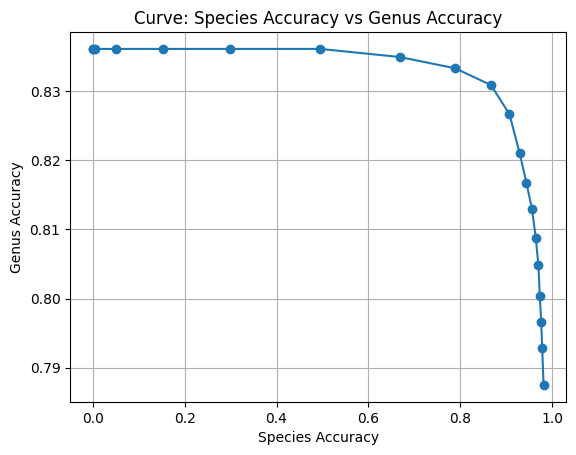

In [131]:
species_accuracies = []
genus_accuracies = []

linear_space = np.linspace(0, 1, 20)
condensed_space = 1 - (1 - linear_space) ** 3
threshold_values = 0.9 + 0.1 * condensed_space

for threshold in threshold_values:
    species_accuracy, genus_accuracy = test(model, threshold, batch_size)
    species_accuracies.append(species_accuracy)
    genus_accuracies.append(genus_accuracy)

# Plotting the curve
plt.plot(species_accuracies, genus_accuracies, marker='o')
plt.xlabel('Species Accuracy')
plt.ylabel('Genus Accuracy')
plt.title('Curve: Species Accuracy vs Genus Accuracy')
plt.grid(True)
plt.show()